# Semana 1: Exploración del problema y del dataset

## 1. Cargar y visualizar señales ECG

#1.1- Introducción:
En esta primera entrega, exploraremos un subconjunto de datos derivados de señales ECG (intervalos RR). El objetivo es familiarizarnos con las variables estadísticas (mean_rr, std_rr, skew_rr, kurt_rr) y analizar cómo se relacionan con el diagnóstico de ritmos normales vs. fibrilación auricular (AFib).

In [27]:
#======================================
# 1.3- Cargar el dataset
#======================================

def plot_ecg_segment(data_dir, duration=10, fs=300):
    import os
    import scipy.io as sio
    import numpy as np
    import matplotlib.pyplot as plt

    mat_files = sorted(f for f in os.listdir(data_dir) if f.endswith('.mat'))
    if not mat_files:
        print(f"⚠️ No se encontraron archivos .mat en {data_dir}")
        return
    file0 = mat_files[0]
    mat = sio.loadmat(os.path.join(data_dir, file0))
    signal = mat.get('val', mat.get('ECG', None))
    if signal is None:
        raise KeyError("La señal no está bajo 'val' ni 'ECG'")
    sig = signal.flatten()

    n = min(len(sig), fs * duration)
    t = np.arange(n) / fs
    plt.figure(figsize=(12,3))
    plt.plot(t, sig[:n], lw=0.8)
    plt.title(f"{file0} — primeros {duration}s")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.xlim(0, duration)
    plt.show()

# Ejemplo de uso (descomenta y ajusta la ruta si tienes .mat):
# plot_ecg_segment('training2017')


# Clonar el repositorio solo si no existe (comentamos la salida)
import os
if not os.path.exists('Proyecto-MachineLearning'):
    # !git clone https://github.com/BorisMejiasII/Proyecto-MachineLearning.git  # clonación silenciosa
    pass

# Cambiar al directorio del proyecto
%cd Proyecto-MachineLearning

# Cargar el CSV
import pandas as pd
rr_df = pd.read_csv('ecg_rr_features_curado.csv')

#======================================
# 1.4- Vista previa
#======================================
print(f"Datos cargados por el ecg_rr_features_curado.csv")
# Configuración para mostrar todo el DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Mostrar la tabla con formato más legible
from IPython.display import display
display(rr_df.style
        .set_table_styles([{
            'selector': 'th',
            'props': [('background-color', '#000'),
                      ('font-weight', 'bold'),
                      ('text-align', 'center')]
        }, {
            'selector': 'td',
            'props': [('padding', '4px'),
                      ('text-align', 'center')]
        }])
        .set_properties(**{'border': '1px solid #ddd'}))


[Errno 2] No such file or directory: 'Proyecto-MachineLearning'
/content/Proyecto-MachineLearning/Proyecto-MachineLearning/Proyecto-MachineLearning/Proyecto-MachineLearning/Proyecto-MachineLearning/Proyecto-MachineLearning/Proyecto-MachineLearning
Datos cargados por el ecg_rr_features_curado.csv


,mean_rr,std_rr,skew_rr,kurt_rr,label
0,849.671415,37.965868,0.404165,3.097078,Normal
1,786.173570,87.045564,0.462868,3.968645,AFib
2,864.768854,49.730056,0.278733,2.297947,Normal
3,952.302986,28.845781,0.260759,2.672338,AFib
4,776.584663,66.450898,0.662505,2.607892,AFib
5,776.586304,25.583127,0.771248,1.536485,Normal
6,957.921282,54.177272,0.485598,3.296120,Normal
7,876.743473,10.806598,0.700707,3.261055,AFib
8,753.052561,23.436279,0.572327,3.005113,Normal
9,854.256004,53.937225,0.370976,2.765413,Normal


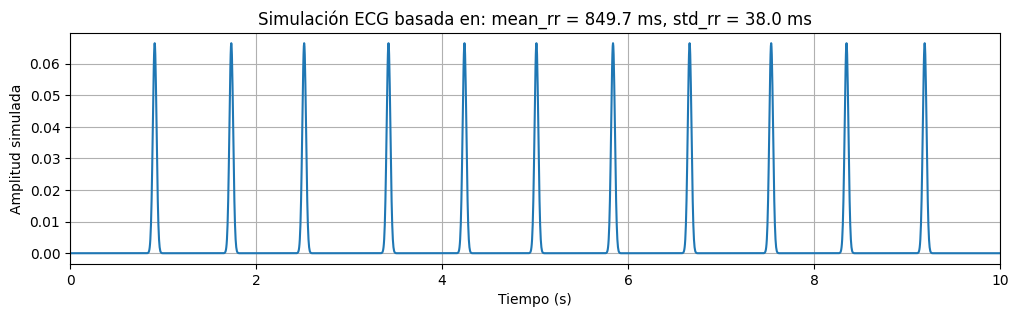

In [39]:
#======================================
# 1.5 - Simular señal ECG desde estadísticas del CSV
#======================================
import numpy as np
import matplotlib.pyplot as plt

def simulate_ecg_from_rr(mean_rr_ms, std_rr_ms, duration_s=10, fs=300):
    """
    Simula una señal ECG simple basada en el RR medio y su desviación.
    """
    rr_mean_s = mean_rr_ms / 1000   # Convertir a segundos
    rr_std_s = std_rr_ms / 1000

    # Tiempo total
    total_samples = fs * duration_s
    t = np.linspace(0, duration_s, total_samples)

    # Generamos picos tipo latidos: ubicaciones aproximadas
    rr_intervals = np.random.normal(loc=rr_mean_s, scale=rr_std_s, size=int(duration_s / rr_mean_s))
    rr_intervals = np.cumsum(rr_intervals)
    rr_intervals = rr_intervals[rr_intervals < duration_s]

    # Simulamos la señal: impulsos tipo R (forma de dientes)
    ecg = np.zeros_like(t)
    for peak_time in rr_intervals:
        idx = int(peak_time * fs)
        if 0 <= idx < len(ecg):
            ecg[idx] = 1  # latido

    # Suavizamos (simulación muy simple)
    from scipy.ndimage import gaussian_filter1d
    ecg_smooth = gaussian_filter1d(ecg, sigma=fs//50)

    # Gráfico
    plt.figure(figsize=(12, 3))
    plt.plot(t, ecg_smooth)
    plt.title(f"Simulación ECG basada en: mean_rr = {mean_rr_ms:.1f} ms, std_rr = {std_rr_ms:.1f} ms")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud simulada")
    plt.xlim(0, duration_s)
    plt.grid(True)
    plt.show()

#======================================
# Ejemplo: usar la primera fila del CSV
#======================================
row = rr_df.iloc[0]  # Puedes cambiar el índice
simulate_ecg_from_rr(row['mean_rr'], row['std_rr'])


## 2. Resumen del artículo base (Clifford et al., 2017)

El artículo base presenta el PhysioNet/Computing in Cardiology Challenge 2017, centrado en la clasificación automática de señales ECG para la detección de fibrilación auricular (AFib). Se describe un conjunto de datos compuesto por señales de corta duración, extraídas de diferentes pacientes, junto con etiquetas clínicas (Normal, AFib, Otros).

El enfoque del artículo sugiere el uso de características simples como los intervalos RR (tiempo entre latidos), los cuales permiten una separación razonable entre ritmos normales y arrítmicos, incluso sin acceder a la señal cruda de ECG. El trabajo sirve como base para tareas de extracción de características, clasificación automática y validación de modelos diagnósticos.


## 3. Análisis del dataset (cantidad de señales, duración, etiquetas, etc.)

In [34]:
#=====================================
# 3. Análisis del dataset
#=====================================

from IPython.display import Markdown, display

# 🔢 Total de registros
display(Markdown(f"**🔢 Total de registros:** {len(rr_df)}"))

# 📊 Distribución de clases
dist = rr_df['label'].value_counts().rename_axis('label').reset_index(name='count')
dist = dist.set_index('label')
display(dist.style
        .bar(subset=['count'], color='#5DADE2')
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('background-color', ''),
                ('font-weight', 'bold'),
                ('text-align', 'center')
            ]},
            {'selector': 'td', 'props': [
                ('padding', '4px'),
                ('text-align', 'center')
            ]}
        ])
        .set_properties(**{'border': '1px solid #ddd'}))

print("==================")

# 📈 Estadísticas por clase
stats = rr_df.groupby('label').describe().T
display(stats.style
        .background_gradient(cmap='Blues')
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('background-color', ''),
                ('font-weight', 'bold'),
                ('text-align', 'center')
            ]},
            {'selector': 'td', 'props': [
                ('padding', '4px'),
                ('text-align', 'center')
            ]}
        ])
        .set_properties(**{'border': '1px solid #ddd'}))


**🔢 Total de registros:** 30

,count
label,
Normal,18
AFib,12


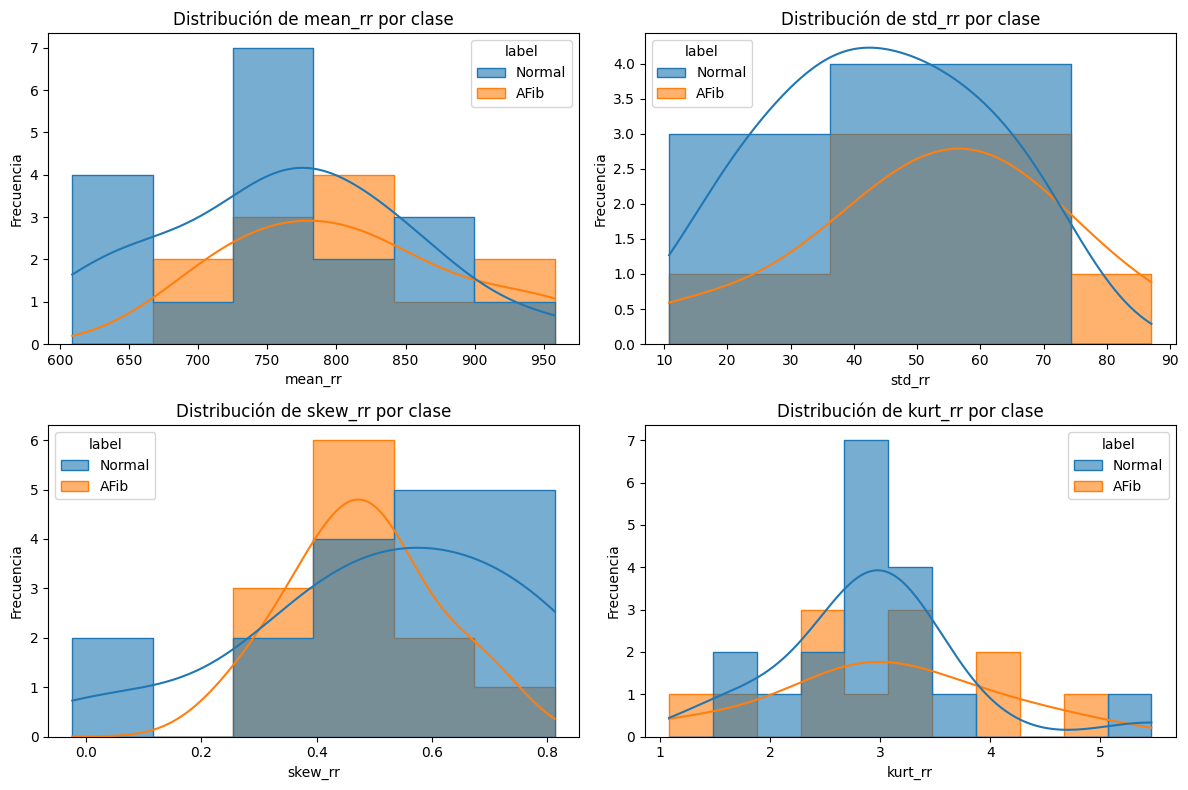

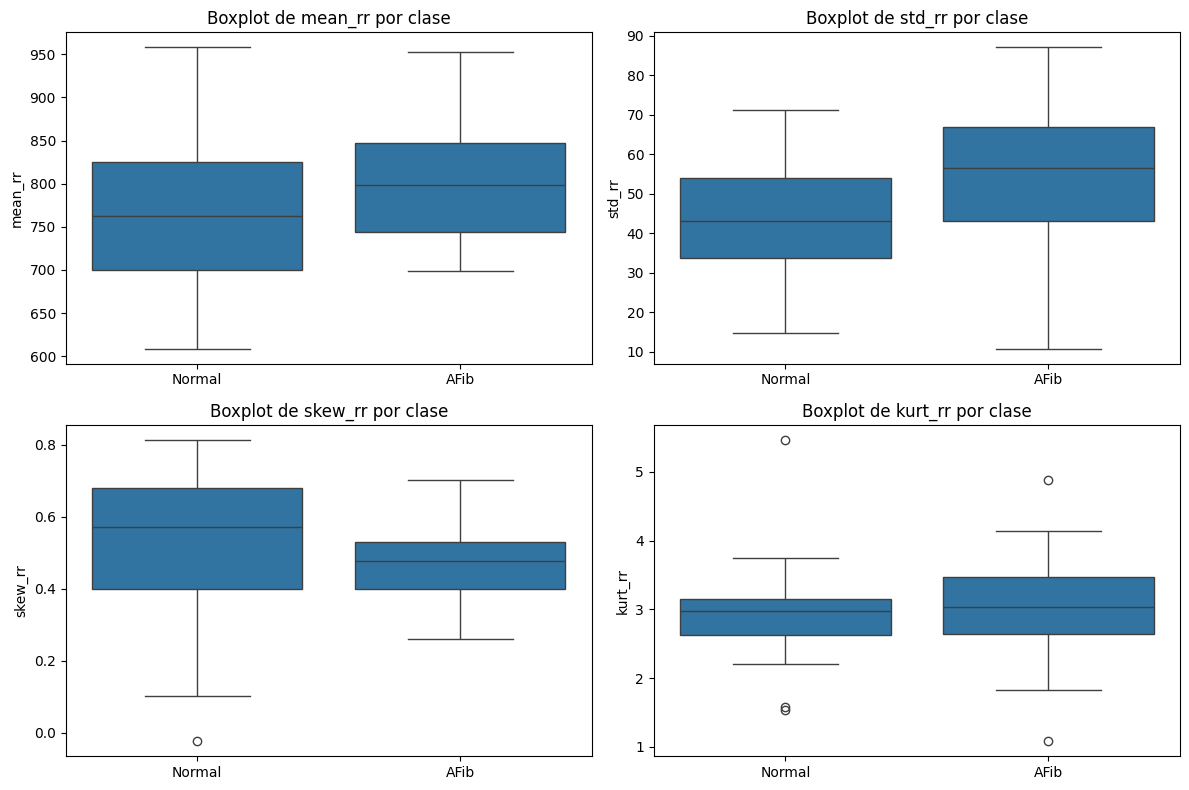

In [37]:
# 4.1 – Histograma + KDE (2x2) sin errores de legend
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, feat in zip(axes.flatten(), features):
    sns.histplot(
        data=rr_df,
        x=feat,
        hue='label',
        kde=True,
        element='step',
        ax=ax,
        alpha=0.6
    )
    ax.set_title(f'Distribución de {feat} por clase')
    ax.set_xlabel(feat)
    ax.set_ylabel('Frecuencia')
# Seaborn ya habrá creado la leyenda una sola vez
fig.tight_layout()
plt.show()


# 4.2 – Boxplots organizados en grid (2x2) sin FutureWarning
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, feat in zip(axes.flatten(), features):
    sns.boxplot(
        data=rr_df,
        x='label',
        y=feat,
        ax=ax          # sin palette o con hue=label
    )
    ax.set_title(f'Boxplot de {feat} por clase')
    ax.set_xlabel('')
    ax.set_ylabel(feat)
fig.tight_layout()
plt.show()


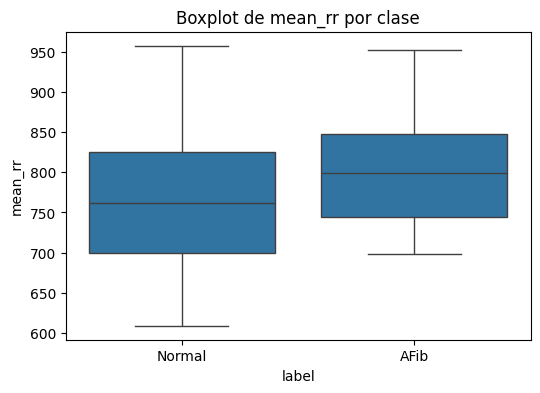

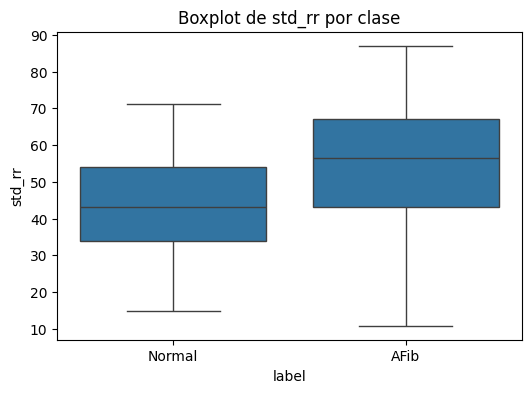

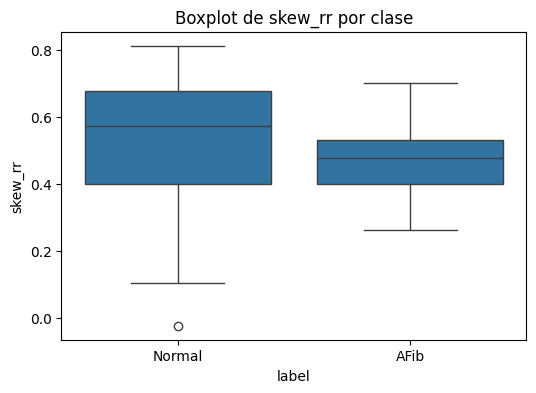

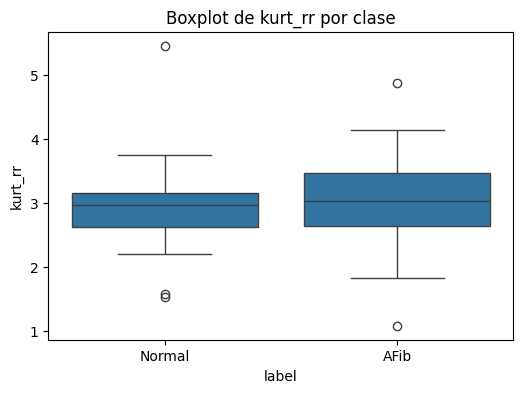

In [ ]:
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=rr_df, x='label', y=feature)
    plt.title(f'Boxplot de {feature} por clase')
    plt.show()


# Conclusión

 - Las variables `std_rr` y `kurt_rr` parecen mostrar diferencias más marcadas entre ritmos normales y AFib.
 - La distribución de `mean_rr` también varía entre clases, aunque con cierto solapamiento.
 - `skew_rr` aporta menor separación visual.
 - El dataset es pequeño (30 muestras); convendría ampliarlo para validar tendencias.
  - Siguiente paso: entrenar y evaluar un clasificador (p.ej. regresión logística o Random Forest).